In [1]:
%load_ext autoreload
%autoreload 2

from msr.training.data.datamodules import PtbXLDataModule
from msr.data.download.ptbxl import FS
from msr.evaluation.plotters import PlotlyPlotter
from msr.evaluation.loggers import MLWandbLogger

rep_type = "whole_signal_waveforms"
TARGET = "diagnostic_class"
project_name = "ptbxl"

BASE_PARAMS = dict(fs=FS, target=TARGET)

In [1]:
x = [1, 2, 3, 4]

In [4]:
from sorcery import dict_of

In [5]:
a=2
b=4
dict_of(a, b)

{'a': 2, 'b': 4}

In [3]:
x

[1, 2, 3]

---
# **ML**

In [19]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from msr.training.trainers import MLClassifierTrainer
from msr.training.data.transforms import Flatten

# transform = Flatten(start_dim=0, end_dim=1)
transform = None

datamodule = PtbXLDataModule(rep_type, transform=transform, **BASE_PARAMS)
datamodule.setup()

model = LGBMClassifier(class_weight='balanced')

ptbxl_ml_trainer = MLClassifierTrainer(model, datamodule)
ptbxl_ml_trainer.fit()

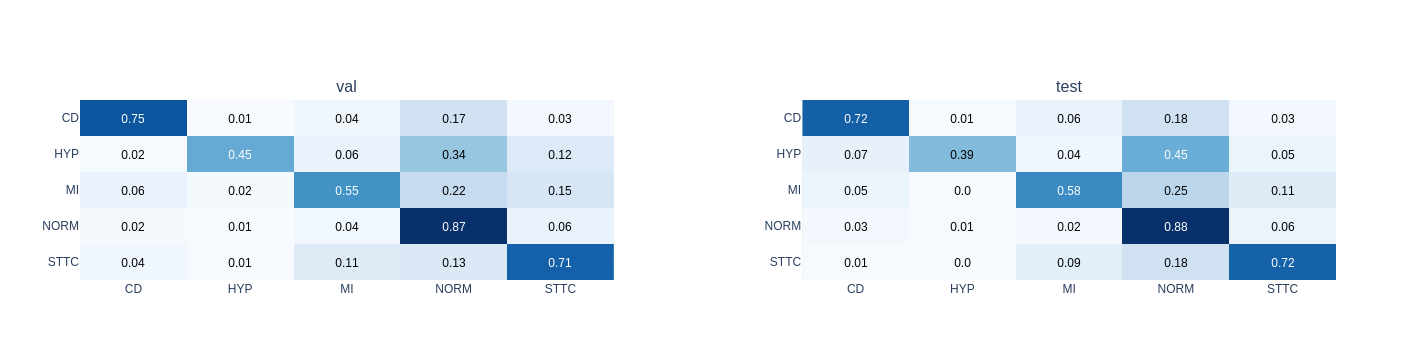

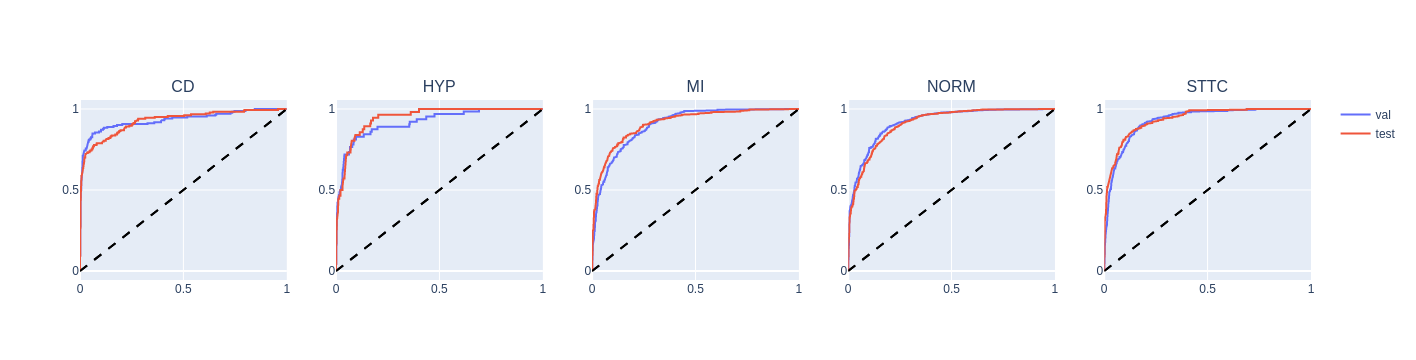

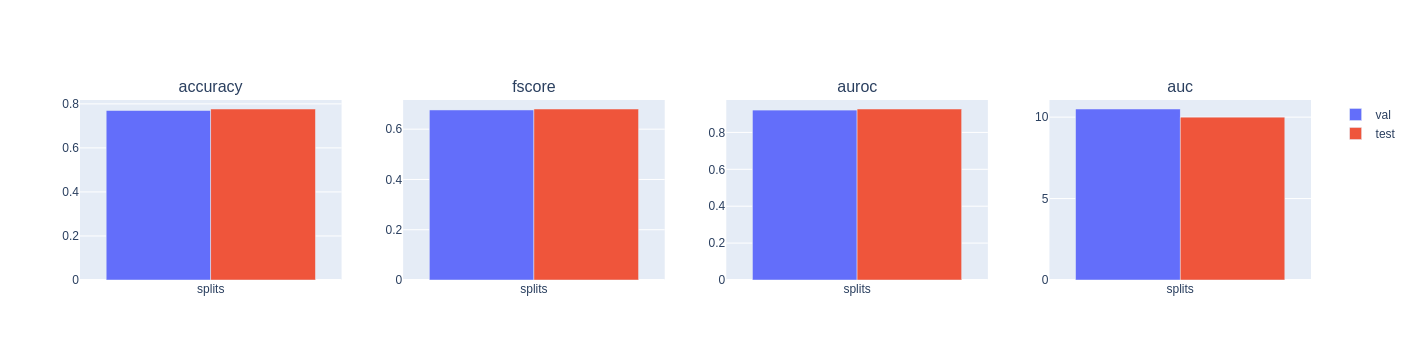

A Jupyter Widget

In [20]:
plotter = PlotlyPlotter()
run_name = f"ML_{rep_type}_{model.__class__.__name__}"

logger = MLWandbLogger(project=project_name, run_name=run_name)
logger.init()

results = ptbxl_ml_trainer.evaluate(
    plotter=plotter,
    logger=logger
)

In [21]:
logger.finish()

---
# **DL**

In [2]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
from torch import nn
from typing import Literal, List, Dict
import torch
import torch.nn.functional as F
from typing import Union, Tuple
from msr.models.modules import ClassifierModule
from msr.models.architectures.networks import CNNExtractor, LinearHead, NeuralNetwork, LSTMExtractor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
datamodule = PtbXLDataModule(rep_type, **BASE_PARAMS)
datamodule.setup()

In [13]:
feature_extractor = CNNExtractor(
    dim=1,
    in_channels=12,
    out_channels=[12, 24, 48, 96, 144],
    maxpool_kernel_size=2,
    kernel_size=[5, 10, 10, 5, 5],
    stride=1,
    padding=0,
    dilation=1
)

feature_extractor = LSTMExtractor(
    in_dim=12,
    hidden_dim=36,
    num_layers=3,
    bidirectional=True,
)


head = LinearHead(feature_extractor.out_dim, out_features=len(datamodule.class_names))

net = NeuralNetwork(
    feature_extractor=feature_extractor, 
    head=head
)

# net = MLPClassifier(in_dim=len(datamodule.feature_names), num_classes=len(datamodule.class_names))


In [14]:
net

NeuralNetwork(
  (feature_extractor): LSTMExtractor(
    (lstm): LSTM(12, 36, num_layers=3, batch_first=True, bidirectional=True)
  )
  (head): LinearHead(
    (net): Linear(in_features=72, out_features=5, bias=True)
  )
)

In [15]:
from msr.training.trainers import DLClassifierTrainer
from pytorch_lightning.loggers import WandbLogger

run_name = f"DL_{rep_type}_{net.__class__.__name__}"

logger = MLWandbLogger(project=project_name, run_name=run_name)
logger.init()

trainer = pl.Trainer(
    logger=WandbLogger(project=project_name, name=run_name, id=logger.id),
    accelerator="auto",
    max_epochs=50
)

model = ClassifierModule(net=net)

ptbxl_dl_trainer = DLClassifierTrainer(trainer, model, datamodule)
ptbxl_dl_trainer.fit()

wandb: Currently logged in as: thawro. Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Unknown Error


/home/shate/.cache/pypoetry/virtualenvs/msr-xbuxOujG-py3.8/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:387: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: ERROR Failed to sample metric: Not Supported
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params
--------------------------------------------
0 | net       | NeuralNetwork | 78.1 K
1 | criterion | NLLLoss       | 0     
--------------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
results = ptbxl_dl_trainer.evaluate(
    plotter=PlotlyPlotter(),
    logger=logger
)

In [ ]:
logger.finish()